In [1]:
%cd '/home/hew/python/genhance/'
%ls

/home/hew/python/genhance
ACE2/  data/  debug/  output/  temp/  tensorboard/  transformers_custom/


In [2]:
!nvidia-smi

Mon Apr 24 22:27:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   62C    P0   427W / 400W |  73916MiB / 81920MiB |    100%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  Off  | 00000000:00:06.0 Off |                    0 |
| N/A   

In [3]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
before_foldx = True

In [5]:
train_data_path = '/home/hew/python/genhance/data/train_new_all_data.pkl'
congen_name = 'congen8_new_ddG_6_layer'
ckpt_step = 'final'
dir = 'generations_[-80]_[2.0]'

pkl_dir = f'/home/hew/storage/storage/genhance/ckpts/{congen_name}/{dir}/'

In [6]:
list(os.walk(pkl_dir))[0]

('/home/hew/storage/storage/genhance/ckpts/congen8_new_ddG_6_layer/generations_[-80]_[2.0]/',
 [],
 ['congen8_new_ddG_6_layer-gens-6600-260000.pkl'])

In [7]:
index = -1
file = list(os.walk(pkl_dir))[0][-1][index]
pkl_path = f'/home/hew/storage/storage/genhance/ckpts/{congen_name}/{dir}/{file}'
pkl_path

'/home/hew/storage/storage/genhance/ckpts/congen8_new_ddG_6_layer/generations_[-80]_[2.0]/congen8_new_ddG_6_layer-gens-6600-260000.pkl'

In [8]:
wt_seq = 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ'
WT_seq = 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ'
constant_region = 'NTNITEEN'
wt_cs_ind = wt_seq.index(constant_region)
wt_cs_ind, wt_seq[32:32 + 8]

(32, 'NTNITEEN')

# Load pkl data

In [9]:
gen_seq_data = open(pkl_path, 'rb')
gen_seq_data = pickle.load(gen_seq_data)
gen_seq_data.keys()

dict_keys(['output_seq_list', 'input_seq_list', 'output_tensor_list', 'repeat_list', 'in_train_data_list'])

In [10]:
gen_seq_data['output_seq_list'][:100]

['KELLYETLKLYLQQKFLLLKYKLKLETLKEYLQLKLFLMELKLKMELKMKLELKQFLLKLMEKYLLEMKLLLKKFLLWKLKQM',
 'QLKETLKLQLKLLKHLTYLYKLKLLMLKTLKLLMLMKLKEKLLTIQELKLKLKLMLQFLKLKLTMLKLKLLKEELLKWKLMMY',
 'LELKTLKMQLLKYFLEKVKLLKLLMLKLKLKLQEYLELKLTLKKLQYLKELKLKLKLKLMLKWTLEKMLLEIMKLCKLLLLKY',
 'YKLEKLTWLKETKLYLHKLKLQLLYTLKLLLYKLKLKTLMLYLKKLELKLLMELKKLMYMLEEMLKLKLMLKLQLKELYELKL',
 'ELEKEKLLEMKLKLTELQLLKLKFLLKYLKLMLELMKYLLKLQLQYLLMMKLKLLKELLKMLQKLLYLKLKALWMLKLLLKKT',
 'ELKKLILQFLKMLKWMLKLLTEKLKLLFKMLQLKLYNMLLKLLMKLKLETLKLMLKKLLEMLELKLKLKLLMFEMKLKLLLYL',
 'EIEKELLLKYLLTMLKELLMLKYLWTLLKLYKLTLLYMLKLYLYLKLKLMLLLKLEMLKLYMMELKLLLKHLLKMTLTLELKL',
 'KEELELKTMLMEMKLLKLLHYLKLYQLLMLKMELKLYKLLKLKLFLKLKWMLELMYLLKQLLKLKLEFLKLKMYLLLKLKLML',
 'KTELELEKLKLLMLKLKLLKLKYLLKLKLLEMLEKLWKMLELKKLLKLKLMIELKLYMLLKLKLKLQLMLTWMLKLTLMLYKL',
 'KYMLETLKKLLLLKYMLEKLKLKLLFKKQLLKLMYLMEKLKLYLKMELTKLLLYKLYELKTLLKLKWLELKLYLKMLLEKLQE',
 'QEKLLMMKLQLKEALWKLMLLKMELEIQKWKLKLILKLKLFLQYLSLKLKLKLEMLKLILKLKLLEHMKLKLLLKLMLKLELK',
 'KLKEIEELKKLLLLKYLELKTELMKLLKLY

### Analyze hamming distance

In [11]:
# Compute hamming distance between MT and WT
def hamming_dist(str1, str2):
    i = 0
    count = 0
    while (i < len(str1)):
        if (str1[i] != str2[i]):
            count += 1
        i += 1
    return count

In [12]:
hamming_dist_list = []
special_seqs = []
drop_seq = 0

In [13]:
for seq in gen_seq_data['output_seq_list']:
    if len(seq) == len(wt_seq) and '<pad>' not in seq and '</s>' not in seq:
        h_dist = hamming_dist(seq, wt_seq)
        hamming_dist_list.append(h_dist)
        if h_dist > 40:
            special_seqs.append(seq)
    else:
        drop_seq += 1

In [14]:
len(hamming_dist_list), drop_seq, len(hamming_dist_list) + drop_seq

(6575, 25, 6600)

In [15]:
print("Hamming distance stats")
print("max: ", np.max(hamming_dist_list))
print("min: ", np.min(hamming_dist_list))
print("median: ", np.median(hamming_dist_list))
print("mean: ", np.mean(hamming_dist_list))
print("std: ", np.std(hamming_dist_list))

Hamming distance stats
max:  83
min:  63
median:  75.0
mean:  75.26296577946768
std:  2.6954498250357446


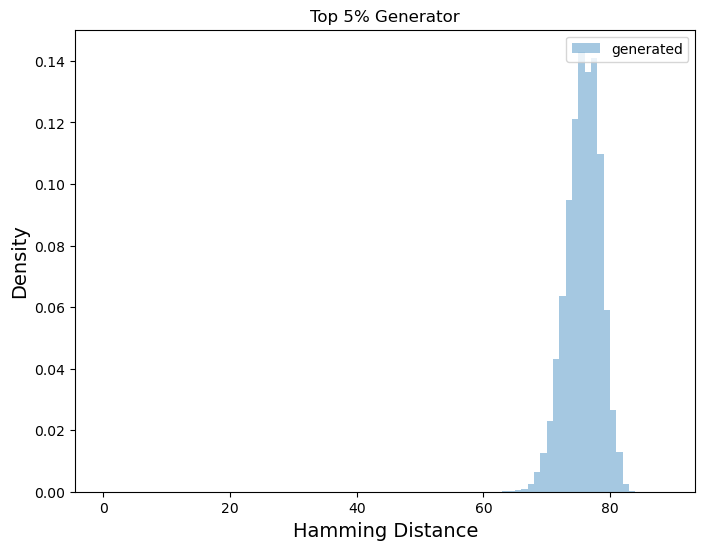

In [16]:
plt.figure(figsize=(8, 6))
plt.hist(hamming_dist_list, density=True, label='generated', bins=[i for i in range(90)], alpha=0.4)
plt.xlabel("Hamming Distance", size=14)
plt.ylabel("Density", size=14)
plt.title("Top 5% Generator")
plt.legend(loc='upper right')

In [17]:
(np.array(hamming_dist_list) <= 8).sum(), (np.array(hamming_dist_list) <= 10).sum()

(0, 0)

In [18]:
(np.array(hamming_dist_list)[:100000] <= 8).sum(), (np.array(hamming_dist_list)[:100000] <= 10).sum()

(0, 0)

In [19]:
dropped_seqs = []
for seq in gen_seq_data['output_seq_list']:
    if constant_region not in seq:
        dropped_seqs.append(seq)
    else:
        cs_ind = seq.index(constant_region)
        if cs_ind != wt_cs_ind:
            dropped_seqs.append(seq)
len(dropped_seqs)

6600

### hamming distance for generator training data

In [20]:
gen_train_df = pd.read_pickle(train_data_path)
gen_train_hamming_dist_list = []
for index, row in gen_train_df.iterrows():
    train_seq = row['MT_seq']
    h_dist = hamming_dist(train_seq, wt_seq)
    gen_train_hamming_dist_list.append(h_dist)

/home/hew/miniconda3/envs/genhance/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


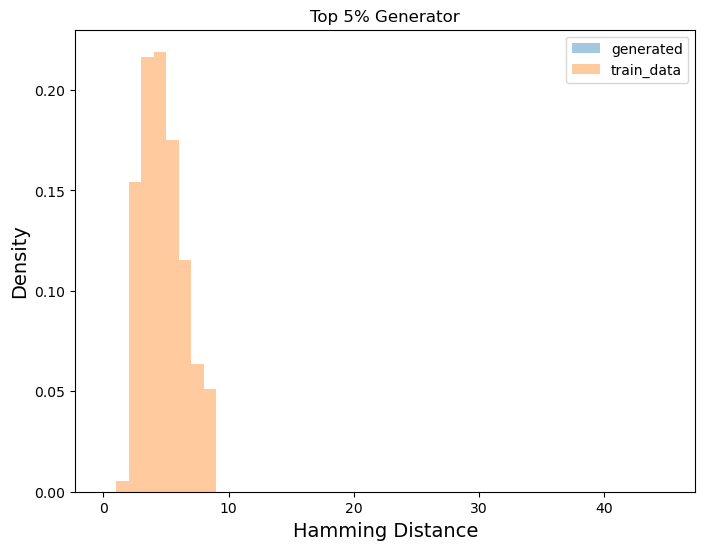

In [21]:
plt.figure(figsize=(8, 6))
plt.hist(hamming_dist_list, density=True, label='generated', bins=[i for i in range(46)], alpha=0.4)
plt.hist(gen_train_hamming_dist_list, density=True, label='train_data', bins=[i for i in range(46)], alpha=0.4)
plt.xlabel("Hamming Distance", size=14)
plt.ylabel("Density", size=14)
plt.title("Top 5% Generator")
plt.legend(loc='upper right')

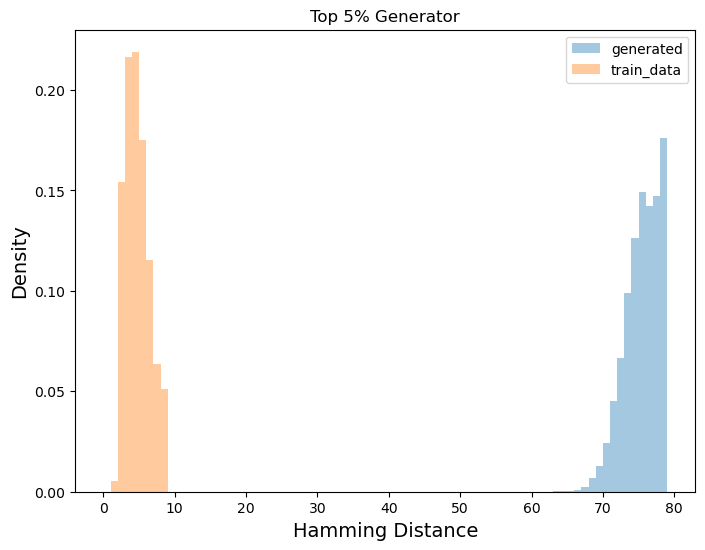

In [22]:
plt.figure(figsize=(8, 6))
plt.hist(hamming_dist_list, density=True, label='generated', bins=[i for i in range(80)], alpha=0.4)
plt.hist(gen_train_hamming_dist_list, density=True, label='train_data', bins=[i for i in range(80)], alpha=0.4)
plt.xlabel("Hamming Distance", size=14)
plt.ylabel("Density", size=14)
plt.title("Top 5% Generator")
plt.legend(loc='upper right')